### Connect to Drive:

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/HOMEWORK 2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1D9HXvl2BPOS8HABf3Mgc_XeBBbY7SjFH/HOMEWORK 2


### Import libraries:

In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [5]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

In [6]:
# library containing ACF and PACF
!pip install statsmodels
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### Load data:

In [7]:
training_data = np.load('training_dataset/training_data.npy', allow_pickle=True)
categories = np.load('training_dataset/categories.npy', allow_pickle=True)
valid_periods = np.load('training_dataset/valid_periods.npy', allow_pickle=True)
training_data = training_data.astype(np.float32) # move to float32 representation
print(np.shape(training_data))
print(np.shape(categories))
print(np.shape(valid_periods))

(48000, 2776)
(48000,)
(48000, 2)


### Data exploration:

#### Timeseries' length:

Timeseries' average length: 198.30022916666667
Timeseries' maximum length: 2776
Timeseries' minimum length: 24


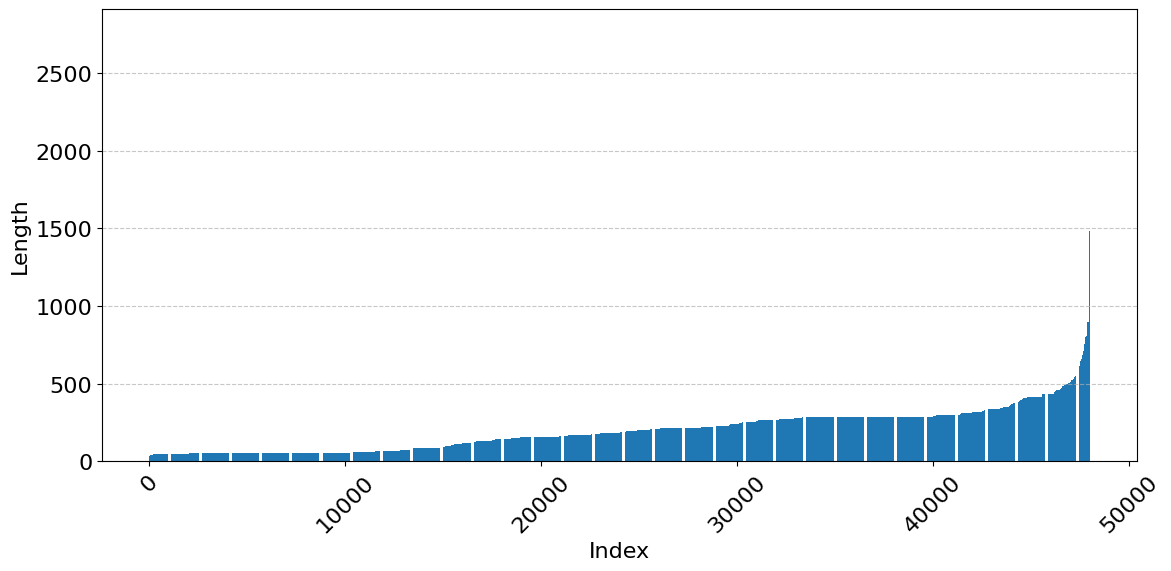

In [8]:
lengths = valid_periods[:,1] - valid_periods[:,0]
id=range(len(lengths))
print("Timeseries' average length:", lengths.mean())
print("Timeseries' maximum length:", lengths.max())
print("Timeseries' minimum length:", lengths.min())

plt.figure(figsize=(12, 6))
plt.bar(id, sorted(lengths), width=0.9)
plt.xlabel('Index')
plt.ylabel('Length')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Category inspection:

In [ ]:
categories = pd.Categorical(categories)
unique_categories, category_counts = np.unique(categories, return_counts=True)
for category, count in zip(unique_categories, category_counts):
    print(f'Category {category}: {count} samples')

Category A: 5728 samples
Category B: 10987 samples
Category C: 10017 samples
Category D: 10016 samples
Category E: 10975 samples
Category F: 277 samples


In [ ]:
indexes_A = np.where(categories == 'A')[0]
indexes_B = np.where(categories == 'B')[0]
indexes_C = np.where(categories == 'C')[0]
indexes_D = np.where(categories == 'D')[0]
indexes_E = np.where(categories == 'E')[0]
indexes_F = np.where(categories == 'F')[0]

idxs = [indexes_A[0], indexes_B[0], indexes_C[0], indexes_D[0], indexes_E[0], indexes_F[0]]
titles = ['Category A - Demography', 'Category B - Finance', 'Category C - Industry', 'Category D - Macroeconomy', 'Category E - Microeconomy', 'Category F - Other'] #Demography, Finance, Industry, Macroeconomy, Microeconomy and Other

ts4plot = training_data[idxs]
#print(np.shape(ts4plot))
vp4plot = valid_periods[idxs]
#print(np.shape(vp4plot))
start_times = [row[0] for row in vp4plot]
min_time = min(start_times)
#print(min_time)

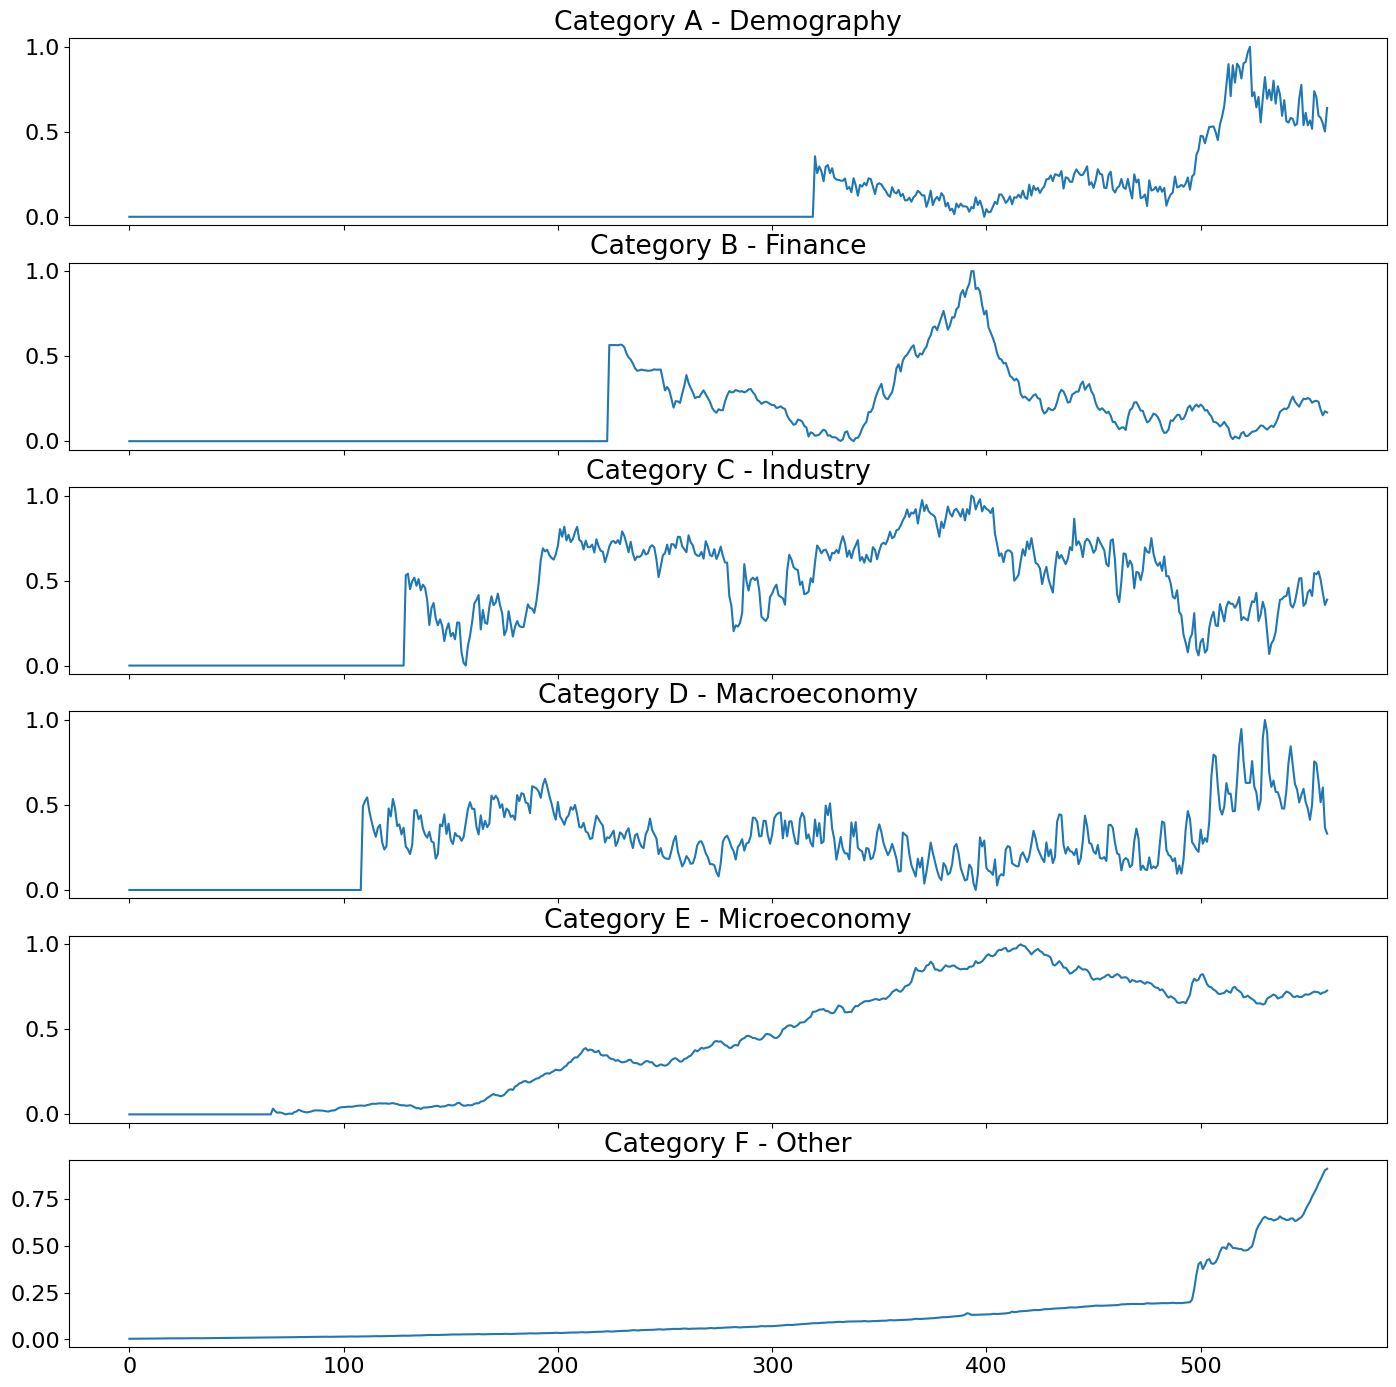

In [ ]:
figs, axs = plt.subplots(len(ts4plot), 1, sharex=True, figsize=(17,17))
for i, (time_series, title) in enumerate(zip(ts4plot, titles)):
    axs[i].plot(time_series[(min_time+100):])
    axs[i].set_title(title)
plt.show()

#### Autocorrelation:

In [ ]:
unique_categories, category_counts = np.unique(categories, return_counts=True)
# store the indexes for each category using a dictionary
category_indexes = {category: np.where(categories == category)[0] for category in unique_categories}
for category, count in zip(unique_categories, category_counts):
    print(f'Category {category}: {count} samples')

In [ ]:
def inspect_time_series_acf_pacf(data, category_indexes, num, lags):
    for category, indexes in category_indexes.items():
        category_data = data[indexes]

        for i in range(num):
            current_ts = category_data[i][valid_periods[i][0]:]

            # ACF
            fig, ax = plt.subplots(figsize=(16, 4))
            plot_acf(current_ts, lags=lags, ax=ax)
            plt.title(f'ACF - Category {category} - Time Series {i+1}')
            plt.show()

            # PACF
            fig, ax = plt.subplots(figsize=(16, 4))
            plot_pacf(current_ts, lags=lags, ax=ax)
            plt.title(f'PACF - Category {category} - Time Series {i+1}')
            plt.show()

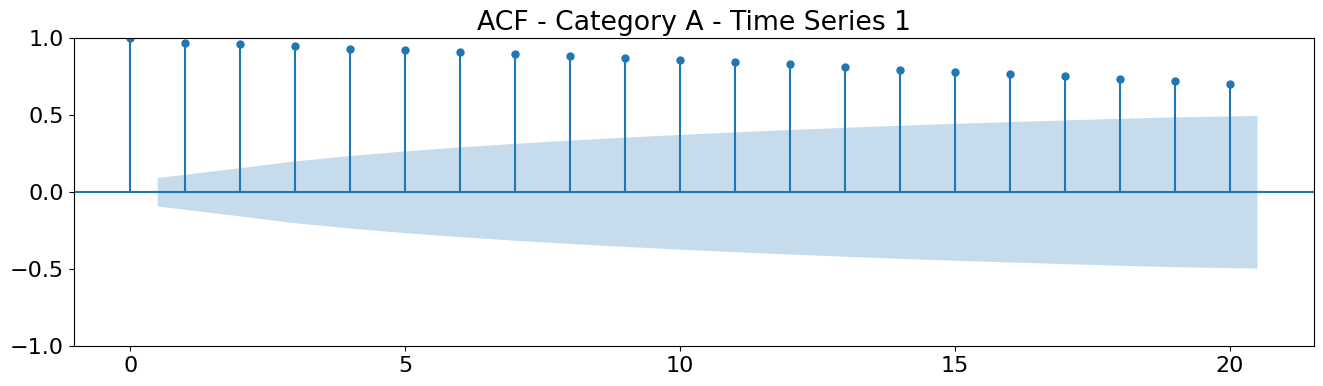

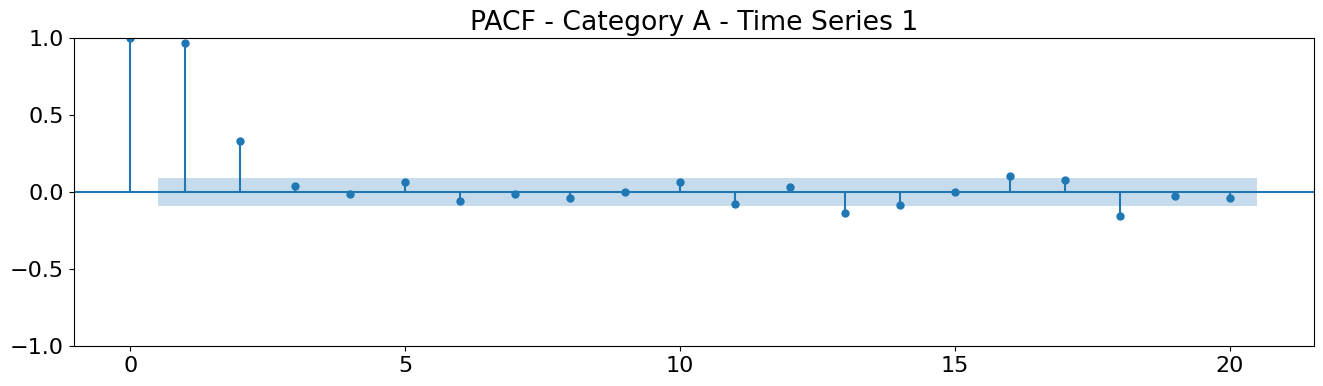

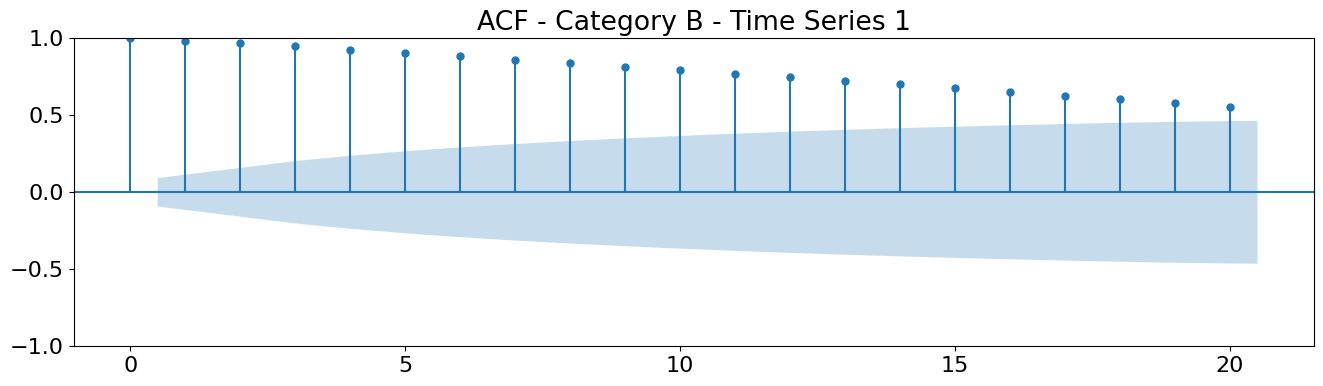

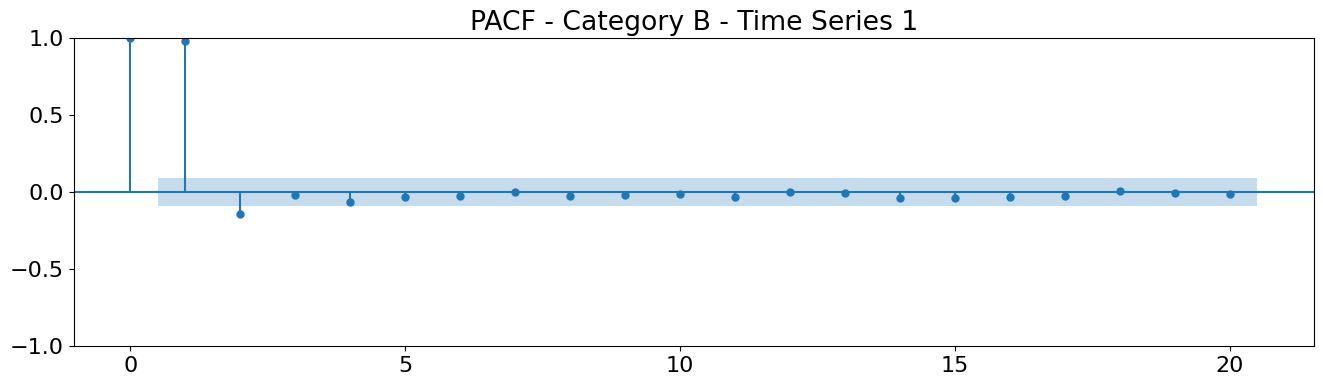

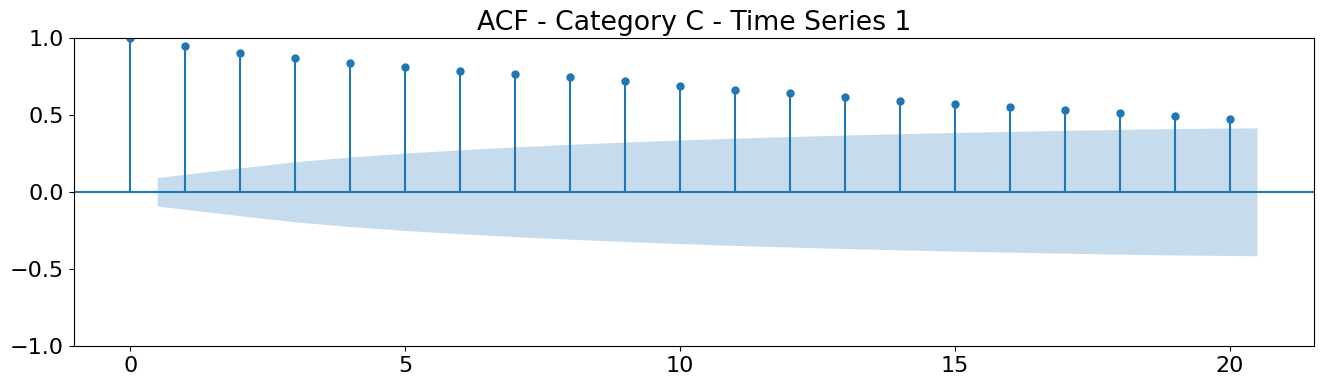

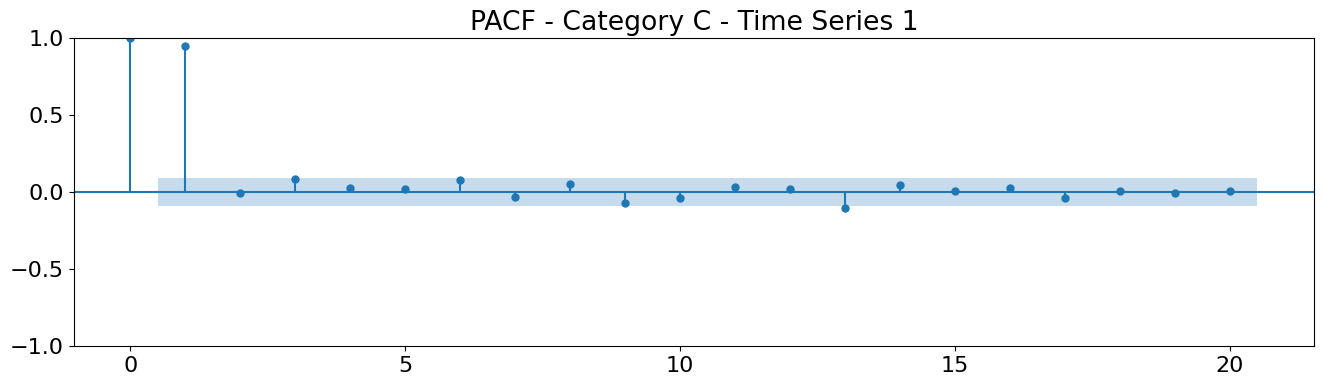

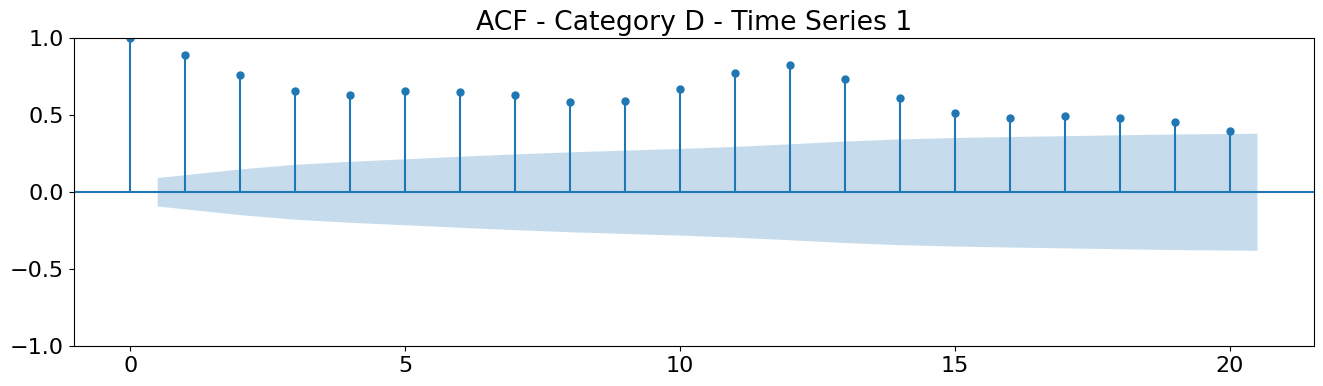

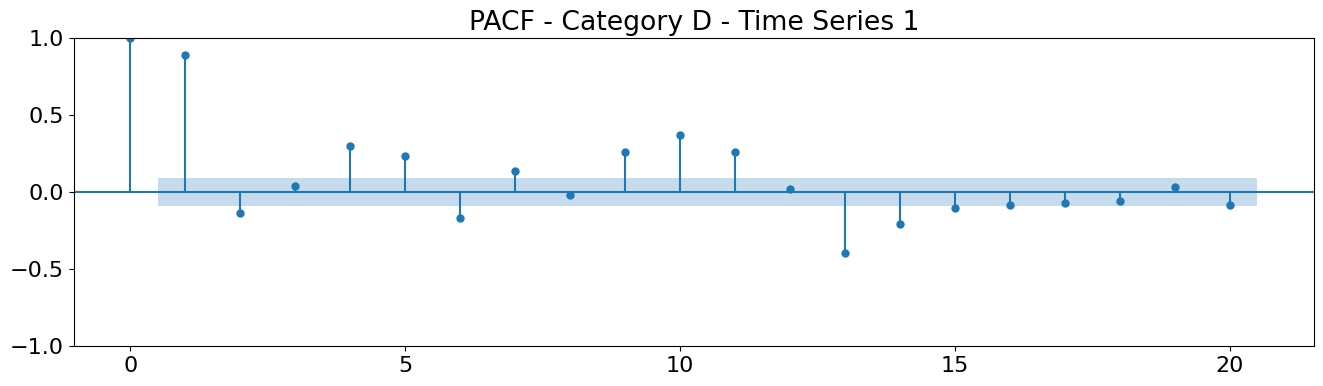

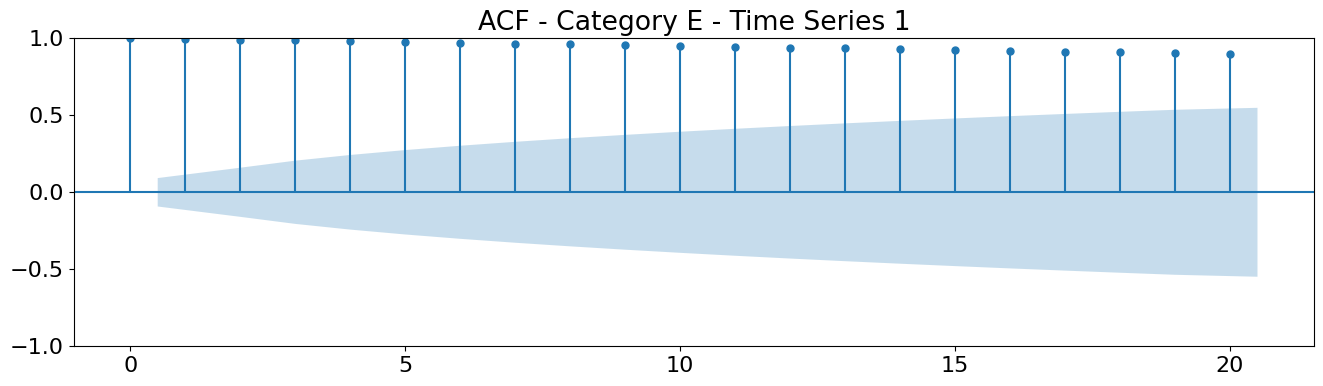

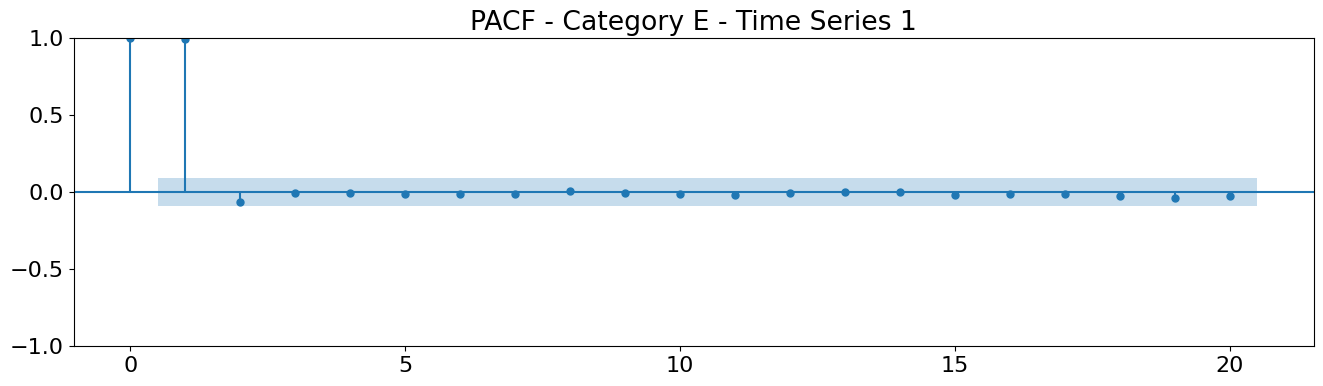

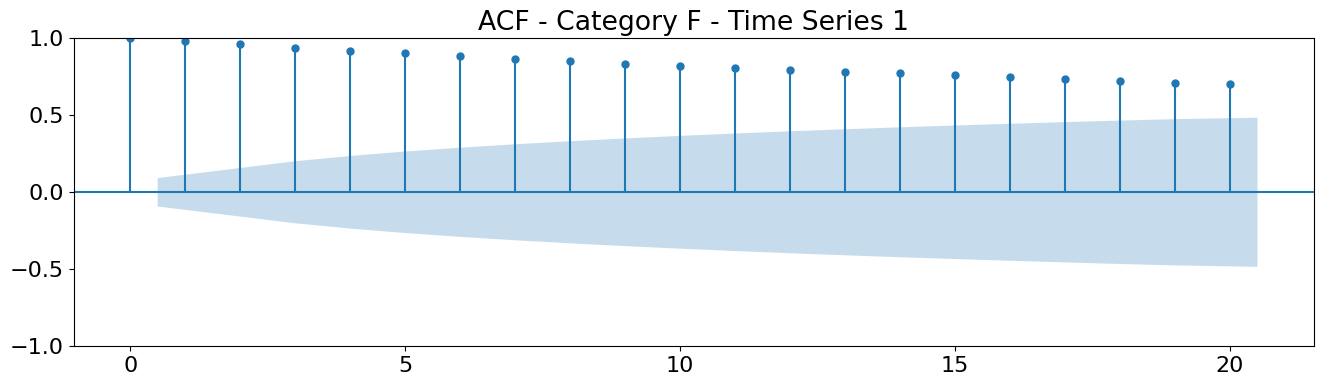

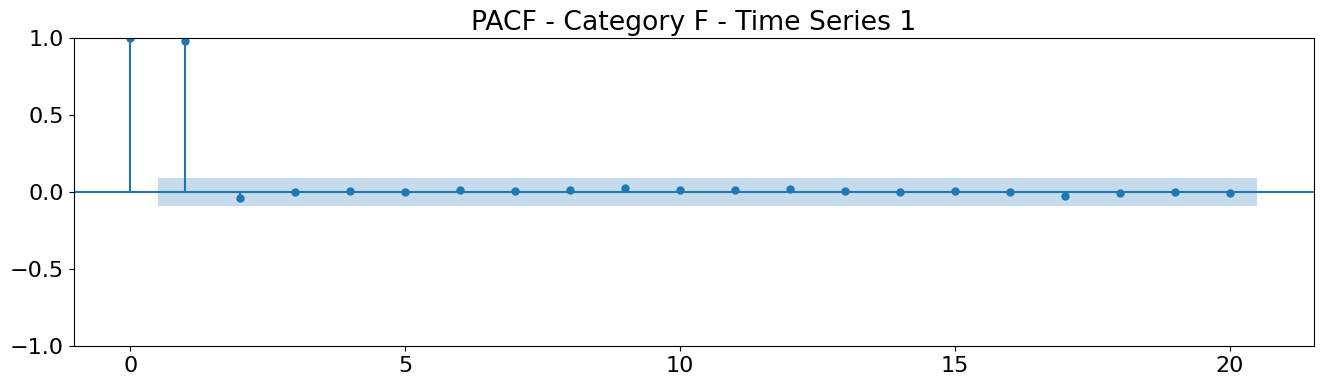

In [ ]:
inspect_time_series_acf_pacf(training_data, category_indexes, 1, 20)

Stationarization (optional)

In [ ]:
for i in range(np.shape(training_data)[0]):
    current_ts = training_data[i][valid_periods[i][0]:] # save the actual ts

    # differencing
    diff_ts = np.diff(current_ts)

Rolling autocorrelation

In [ ]:
window = 200
stride = 25
num = np.shape(training_data)[0]
length = np.shape(training_data)[1]

In [ ]:
# define rolling autocorrelation
def rolling_autocorrelation(series, window_size, stride):
    acf_values = []

    for i in range(0, len(series) - window_size + 1, stride):
        current_window = series[i:i+window_size]
        acf_value = acf(current_window, nlags=1)[1]  # Use lag 1 autocorrelation
        acf_values.append(acf_value)

    return np.array(acf_values)

In [ ]:
def inspect_rolling_acf(data, category_indexes, n, lags, window_size=window, strd=stride):
    for category, indexes in category_indexes.items():
        category_data = data[indexes]

        for i in range(n):
            current_ts = category_data[i][valid_periods[i][0]:]

            # rolling autocorrelation on a single, univariate time series
            rolling_acf_values = rolling_autocorrelation(current_ts, window, stride)
            fig, ax = plt.subplots(figsize=(16, 4))
            ax.plot(range(0, len(current_ts) - window + 1, stride), rolling_acf_values)
            plt.title(f'Rolling ACF - Category {category} - Time Series {i+1}')
            plt.xlabel('Time')
            plt.ylabel('Autocorrelation')
            plt.show()

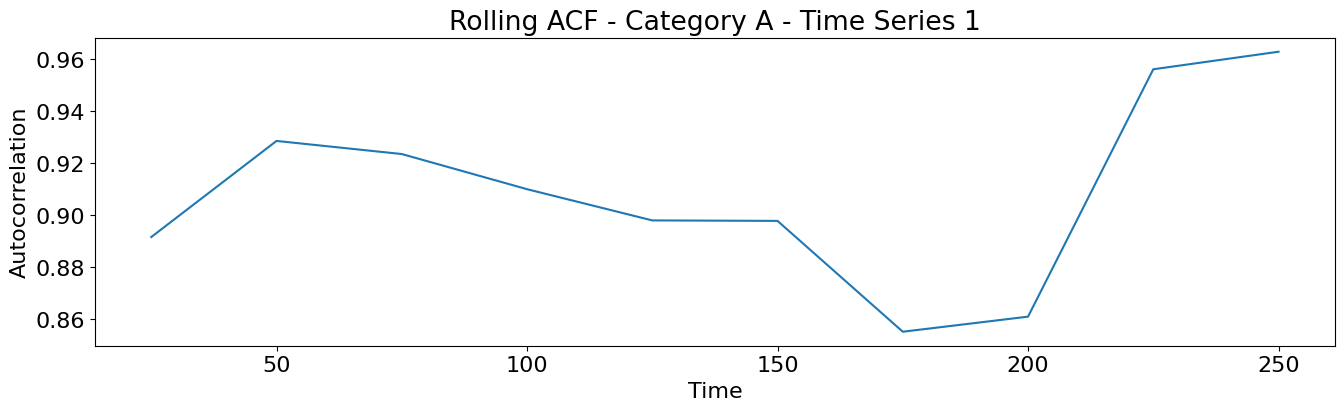

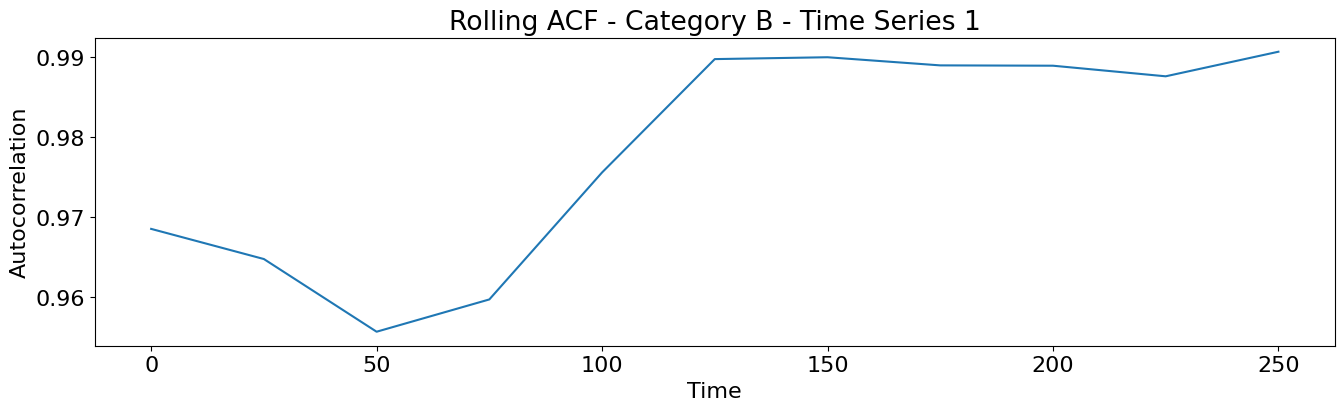

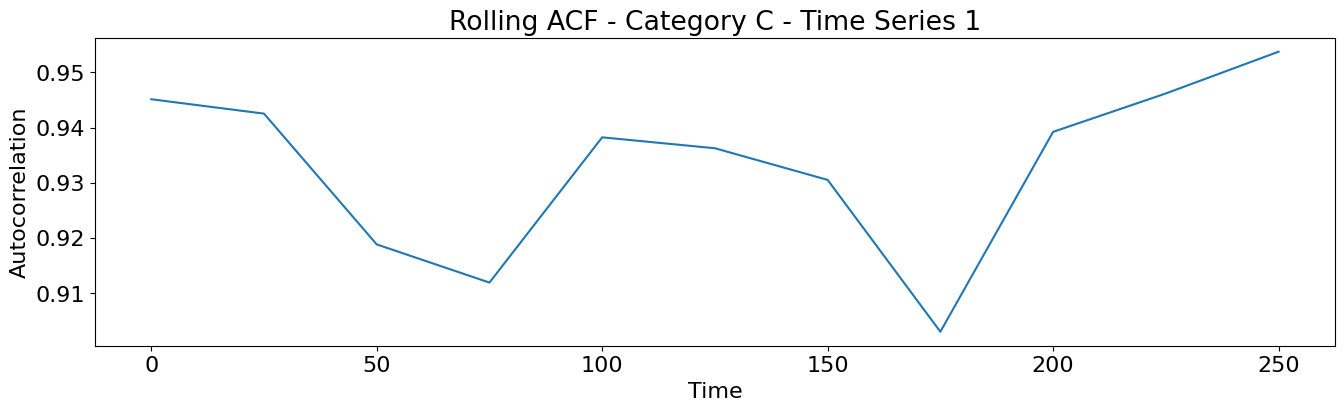

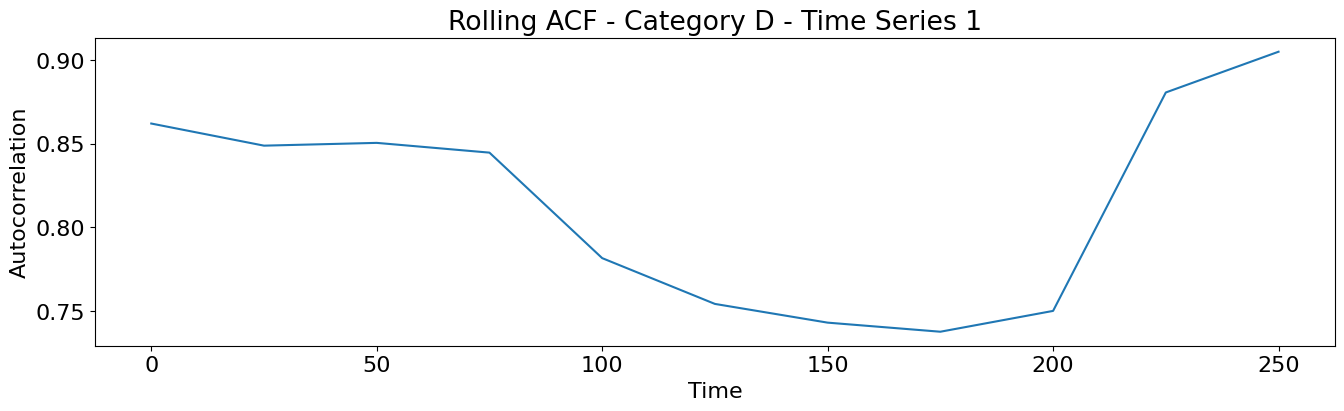

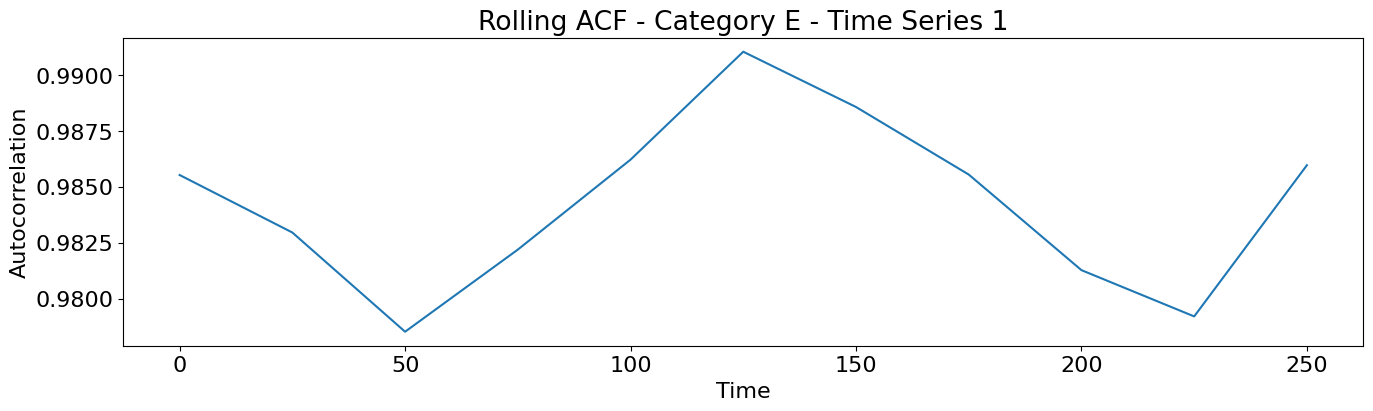

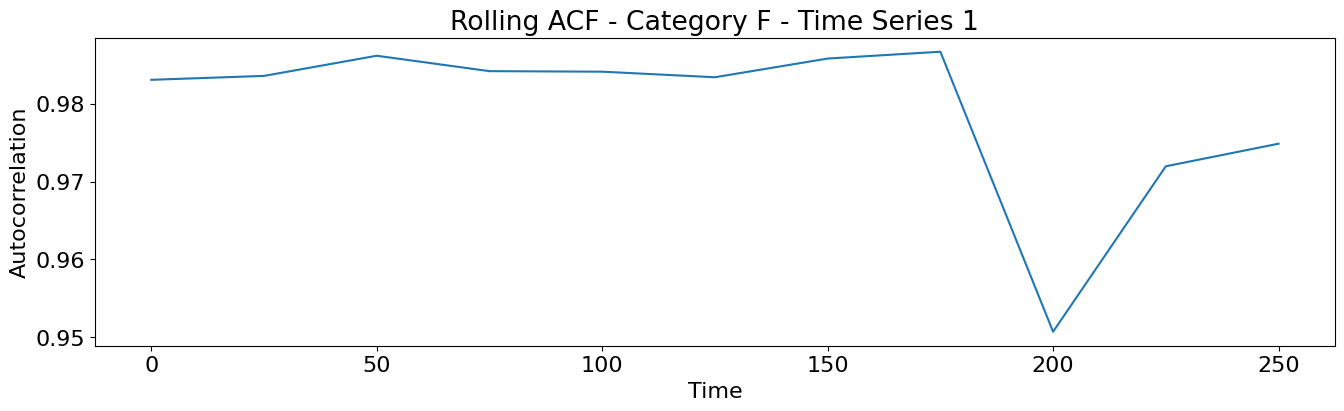

In [ ]:
inspect_rolling_acf(training_data, category_indexes, 1, 20, window_size=window, strd=stride)

### Preprocessing:

#### Robust Standardization with valid periods (optional)

In [ ]:
length = np.shape(training_data)[1] # 2776

scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)

for i in range(np.shape(training_data)[0]): # for each timeseries:
      temp = training_data[i][valid_periods[i][0]:] # save the actual ts
      re_temp = temp.reshape(1, -1)                 # reshape to a 2D array

      re_temp = np.transpose(re_temp)               # transpose to use scaler

      scaled_series = scaler.fit_transform(re_temp) # apply RobustScaler on temp

      scaled_series = np.ravel(scaled_series)       # re-shape back to add padding

      # re-apply the 0-padding so we end up with a usable dataset:
      padding_len =  length - np.shape(temp)[0]
      padding = np.zeros(padding_len, dtype='float32')
      # padding ahead and substitute values in training data
      training_data[i] = np.concatenate((padding, scaled_series))


Rescale in range [0,1]:

In [ ]:
for i in range(np.shape(training_data)[0]): # for each timeseries:
      temp = training_data[i][valid_periods[i][0]:] # save the actual ts

      X_min = temp.min()
      X_max = temp.max()

      scaled_series = (temp-X_min)/(X_max-X_min) # rescale within (0,1)

      # re-apply the 0-padding so we end up with a usable dataset:
      padding_len =  length - np.shape(temp)[0]
      padding = np.zeros(padding_len, dtype='float32')
      # padding ahead and substitute values in training data
      training_data[i] = np.concatenate((padding, scaled_series))


####New Valid Periods (optional)

we check if there are timeseries with zero-padding also into the valid periods, at the beginning or at the end

In [ ]:
# Find the beginning of each series by detecting non-zero elements
new_valid_periods = np.concatenate((np.zeros(48000, dtype=int)[:,np.newaxis], np.full(48000, 2776)[:,np.newaxis]), axis=1)
for i in range(48000):
    non_zero_indices = np.where(training_data[i] != 0)[0]
    if len(non_zero_indices) > 0:
        new_valid_periods[i,0] = non_zero_indices[0]
        new_valid_periods[i,1] = non_zero_indices[-1]

print(np.shape(new_valid_periods))
new_lengths = new_valid_periods[:,1] - new_valid_periods[:,0]

(48000, 2)


In [ ]:
np.where(new_valid_periods[:,0]-valid_periods[:,0] > 20)

(array([  562,  2576,  2578,  2579, 26276, 26278, 27302, 27644, 28040,
        28065, 30550, 30724, 37548, 37569, 38931, 39047, 41286, 44828]),)

In [ ]:
np.where(2776 - new_valid_periods[:,1] > 20)

(array([ 2991, 34392]),)

only 20 series have more than 20 zeros at the beginning or at the end, so we decide to keep the original valid_periods because it isn't going to affect the models

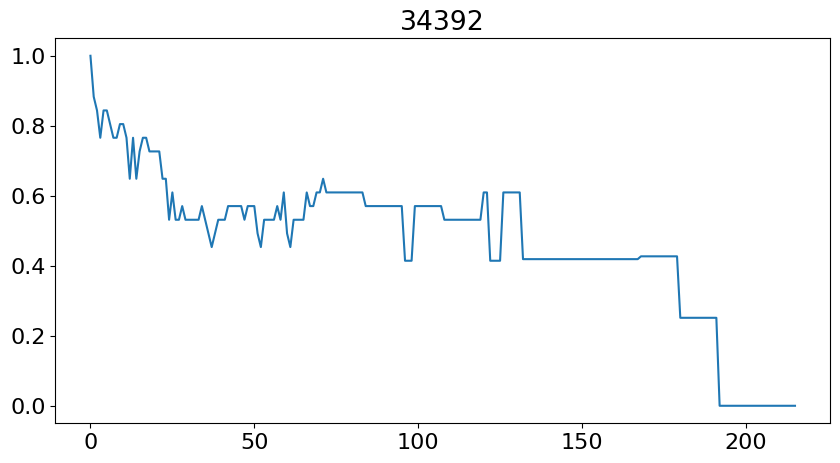

In [ ]:
figs, axs = plt.subplots(1,1,sharex=True, figsize=(10,5))
ts = 34392 #[562,  2576,  2578,  2579, 26276, 26278, 27302, 27644, 28040, 28065, 30550, 30724, 37548, 37569, 38931, 39047, 41286, 44828]
#the only time series that have more than 20 zeros in the beginning
#[ 2991, 34392] time series that have more than 20 zeros in the end
axs.plot(training_data[ts, valid_periods[ts,0]:valid_periods[ts,1]])
axs.set_title(ts)
plt.show()

#### Train-Test split:

In [9]:
# split: train 95%, test 5%

indexes_A = np.where(categories == 'A')[0]
indexes_B = np.where(categories == 'B')[0]
indexes_C = np.where(categories == 'C')[0]
indexes_D = np.where(categories == 'D')[0]
indexes_E = np.where(categories == 'E')[0]
indexes_F = np.where(categories == 'F')[0]

n_A = int(0.05 * len(indexes_A))
n_B = int(0.05 * len(indexes_B))
n_C = int(0.05 * len(indexes_C))
n_D = int(0.05 * len(indexes_D))
n_E = int(0.05 * len(indexes_E))
n_F = int(0.05 * len(indexes_F))

test_indexes_A = np.random.choice(indexes_A, size=n_A, replace=False)
test_indexes_B = np.random.choice(indexes_B, size=n_B, replace=False)
test_indexes_C = np.random.choice(indexes_C, size=n_C, replace=False)
test_indexes_D = np.random.choice(indexes_D, size=n_D, replace=False)
test_indexes_E = np.random.choice(indexes_E, size=n_E, replace=False)
test_indexes_F = np.random.choice(indexes_F, size=n_F, replace=False)

train_indexes_A = np.setdiff1d(indexes_A, test_indexes_A)
train_indexes_B = np.setdiff1d(indexes_B, test_indexes_B)
train_indexes_C = np.setdiff1d(indexes_C, test_indexes_C)
train_indexes_D = np.setdiff1d(indexes_D, test_indexes_D)
train_indexes_E = np.setdiff1d(indexes_E, test_indexes_E)
train_indexes_F = np.setdiff1d(indexes_F, test_indexes_F)

test_data_A = training_data[test_indexes_A]
test_data_B = training_data[test_indexes_B]
test_data_C = training_data[test_indexes_C]
test_data_D = training_data[test_indexes_D]
test_data_E = training_data[test_indexes_E]
test_data_F = training_data[test_indexes_F]

train_data_A = training_data[train_indexes_A]
train_data_B = training_data[train_indexes_B]
train_data_C = training_data[train_indexes_C]
train_data_D = training_data[train_indexes_D]
train_data_E = training_data[train_indexes_E]
train_data_F = training_data[train_indexes_F]

valid_periods_test_A = valid_periods[test_indexes_A]
valid_periods_test_B = valid_periods[test_indexes_B]
valid_periods_test_C = valid_periods[test_indexes_C]
valid_periods_test_D = valid_periods[test_indexes_D]
valid_periods_test_E = valid_periods[test_indexes_E]
valid_periods_test_F = valid_periods[test_indexes_F]

valid_periods_train_A = valid_periods[train_indexes_A]
valid_periods_train_B = valid_periods[train_indexes_B]
valid_periods_train_C = valid_periods[train_indexes_C]
valid_periods_train_D = valid_periods[train_indexes_D]
valid_periods_train_E = valid_periods[train_indexes_E]
valid_periods_train_F = valid_periods[train_indexes_F]

test_data = np.concatenate((test_data_A, test_data_B, test_data_C, test_data_D, test_data_E, test_data_F))
train_data = np.concatenate((train_data_A, train_data_B, train_data_C, train_data_D, train_data_E, train_data_F))
test_valid_periods = np.concatenate((valid_periods_test_A, valid_periods_test_B, valid_periods_test_C, valid_periods_test_D, valid_periods_test_E, valid_periods_test_F))
train_valid_periods = np.concatenate((valid_periods_train_A, valid_periods_train_B, valid_periods_train_C, valid_periods_train_D, valid_periods_train_E, valid_periods_train_F))

print(np.shape(test_data))
print(np.shape(train_data))
print(np.shape(test_valid_periods))
print(np.shape(train_valid_periods))

(2396, 2776)
(45604, 2776)
(2396, 2)
(45604, 2)


#### Parameters setting:

In [10]:
# set window, stride and telescope and other parameters
window = 200
stride = 25 #or 10, 20, 50
autoregressive_telescope = 9 #or 1,2,3,6. in case of direct forecasting, set it equal to telescope
telescope = 18
max_padding = 150
#best parameters found with grid search

In [11]:
# define the hyperparameters
batch_size = 128
seq_len = 64
depth = 256
heads = 8
d_model = 512
epochs = 200

#### Timeseries preprocessing:

In [12]:
def build_sequences(training_data, valid_periods, window=200, stride=20, telescope=100, max_padding=200):

    # max_padding = maximum length of 0-padding portion in a sequence, default=200 -> no limits to 0-padding length

    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []

    for i in range(np.shape(training_data)[0]): # for each timeseries:

      temp = training_data[i][valid_periods[i][0]:]
      padding_len = window - len(temp)%window

      if padding_len > max_padding and len(temp) > window : # too long padding needed -> avoid such sequences by discarding the excess portion
        temp = temp[len(temp)%window:]
      '''if len(temp) < window :
          while len(temp) < (window - max_padding):
          temp2 = temp
          temp = np.concatenate((temp, temp2))'''
      #not recommended, better to keep zero padding

      padding = np.zeros(padding_len, dtype='float32')
      temp = np.concatenate((padding, temp))
      # il padding lo mettiamo in testa per influenzare il minimo possibile la predizione da fare in coda

      for idx in np.arange(0,len(temp)-window-telescope,stride):
        dataset.append(temp[idx:idx+window])
        labels.append(temp[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [13]:
X_train, y_train = build_sequences(train_data, train_valid_periods, window, stride, autoregressive_telescope, max_padding=max_padding)
# max_padding=150 -> 201586 sequences, no max_padding -> 208592 sequences
X_test, y_test = build_sequences(test_data, test_valid_periods, window, stride, autoregressive_telescope, max_padding=max_padding)
X, y = build_sequences(training_data, valid_periods, window, stride, autoregressive_telescope, max_padding=max_padding)
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(204516, 200)
(204516, 9)
(10713, 200)
(10713, 9)


In [14]:
input_shape = (X_train.shape[1],1)
print(input_shape)
output_shape = (y_train.shape[1],1)
print(output_shape)

(200, 1)
(9, 1)


### Baseline Model:

In [ ]:
class ConstantValuePredictor(BaseEstimator, RegressorMixin):
    def fit(self, X, y=None):
        return self

    def predict(self, X):

        predictions = np.empty((0, telescope))
        for i in range(np.shape(X)[0]):
          vector = np.full(telescope, fill_value=X[i][-1])
          predictions = np.vstack((predictions, vector))
        predictions = np.array(predictions)

        return predictions

In [ ]:
X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=150)
#print(np.shape(X_test_reg))
#print(np.shape(y_test_reg))

(10567, 200)
(10567, 18)


In [ ]:
baseline_model = ConstantValuePredictor()
predictions_test = baseline_model.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, predictions_test)
mae = mean_absolute_error(y_test_reg, predictions_test)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.016238543618079037
Mean Absolute Error (MAE): 0.08183972395751239


### Evaluation and plot functions

In [ ]:
# load the desired model:
model = tfk.models.load_model('GRU_9_150')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 9

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=max_padding)
print(np.shape(X_test_reg))
print(np.shape(y_test_reg))

(10567, 200)
(10567, 18)


In [23]:
def compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope):
  # Autoregressive Forecasting:
  reg_predictions = np.array([])
  X_temp = X_test_reg

  for reg in range(0,telescope,autoregressive_telescope):

    pred_temp = model.predict(X_temp, verbose = 0)
    #print(np.shape(pred_temp))
    pred_temp = np.reshape(pred_temp, (pred_temp.shape[0],pred_temp.shape[1]))
    #print(np.shape(pred_temp))

    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    #print(np.shape(reg_predictions))

    X_temp = np.concatenate((X_temp[:,autoregressive_telescope:],pred_temp), axis=1)


  mse = mean_squared_error(y_test_reg, reg_predictions)
  mae = mean_absolute_error(y_test_reg, reg_predictions)
  print("Mean Squared Error (MSE):", mse)
  print("Mean Absolute Error (MAE):", mae)

  return mse, mae

In [ ]:
mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.008211325
Mean Absolute Error (MAE): 0.057796963


In [15]:
def plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope):

    # compute predictions
    reg_predictions = np.array([])
    X_temp = X_test_reg
    for reg in range(0,telescope,autoregressive_telescope):

      pred_temp = model.predict(X_temp, verbose = 0)
      #print(np.shape(pred_temp))
      pred_temp = np.reshape(pred_temp, (pred_temp.shape[0],pred_temp.shape[1]))
      #print(np.shape(pred_temp))

      if(len(reg_predictions)==0):
          reg_predictions = pred_temp
      else:
          reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
      #print(np.shape(reg_predictions))

      X_temp = np.concatenate((X_temp[:,autoregressive_telescope:],pred_temp), axis=1)

    # plot true data and predictions
    true = np.concatenate((X_test_reg, y_test_reg), axis=1)
    predicted = np.concatenate((X_test_reg, reg_predictions), axis=1)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(predicted[1], label='Forecasted Data', color='orange')
    ax.plot(true[1], label='True Data', color='blue')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')
    ax.set_title('True Data vs Forecasted Data')
    ax.legend()

    # vertical dashed line at timestamp 200 to visually separate predictions
    ax.axvline(x=200, color='grey', linestyle='--')

    plt.show()

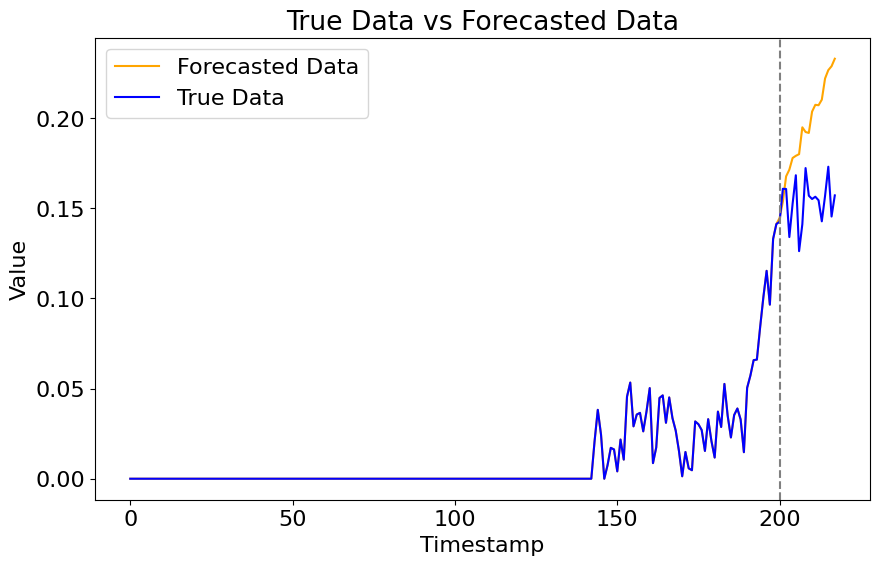

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

### Attention mechanism:

In [18]:
# Attention layer implementation:

class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        #context_vector = tf.expand_dims(context_vector, axis=-1)

        return context_vector

### Final Model: GRU + Attention + Dense

In [16]:
def build_RNN_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape >= output_shape, "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x= tfkl.GRU(256, return_sequences=True)(input_layer)
    x=Attention(256)(x)
    output_layer= tfkl.Dense(output_shape[0])(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='RNN_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 gru_1 (GRU)                 (None, 200, 256)          198912    
                                                                 
 attention (Attention)       (None, 256)               66049     
                                                                 
 dense_2 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 267274 (1.02 MB)
Trainable params: 267274 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


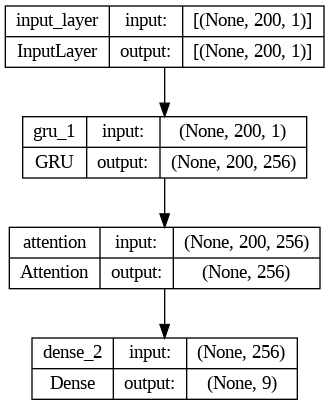

In [19]:
model = build_RNN_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-4)
    ]
).history

model.save('GRU_9_150')

Epoch 1/200
1444/1444 [==============================] - 47s 30ms/step - loss: 0.0165 - val_loss: 0.0087 - lr: 0.0010
Epoch 2/200
1444/1444 [==============================] - 42s 29ms/step - loss: 0.0084 - val_loss: 0.0076 - lr: 0.0010
Epoch 3/200
1444/1444 [==============================] - 42s 29ms/step - loss: 0.0069 - val_loss: 0.0070 - lr: 0.0010
Epoch 4/200
1444/1444 [==============================] - 42s 29ms/step - loss: 0.0061 - val_loss: 0.0064 - lr: 0.0010
Epoch 5/200
1444/1444 [==============================] - 42s 29ms/step - loss: 0.0059 - val_loss: 0.0066 - lr: 0.0010
Epoch 6/200
1444/1444 [==============================] - 42s 29ms/step - loss: 0.0059 - val_loss: 0.0063 - lr: 0.0010
Epoch 7/200
1444/1444 [==============================] - 42s 29ms/step - loss: 0.0057 - val_loss: 0.0062 - lr: 0.0010
Epoch 8/200
1444/1444 [==============================] - 42s 29ms/step - loss: 0.0056 - val_loss: 0.0064 - lr: 0.0010
Epoch 9/200
1444/1444 [==============================] -

In [20]:
# load the desired model:
model = tfk.models.load_model('GRU_9_150')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 9

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=max_padding)
print(np.shape(X_test_reg))
print(np.shape(y_test_reg))

(10567, 200)
(10567, 18)


In [24]:
mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.008211325
Mean Absolute Error (MAE): 0.057796963


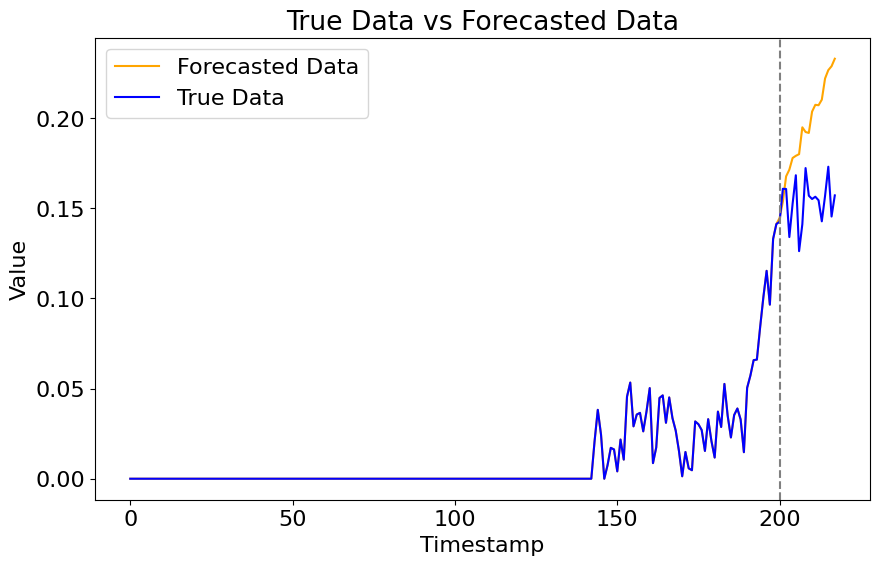

In [22]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

same model but with autoregressive_telescope=9:

In [ ]:
# load the desired model:
model = tfk.models.load_model('GRU_6_150')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 6

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=max_padding)
print(np.shape(X_test_reg))
print(np.shape(y_test_reg))

(10567, 200)
(10567, 18)


In [ ]:
mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.008706035
Mean Absolute Error (MAE): 0.059126154


### First Model: Bidirectional LSTM + Convolution + Attention + Dense

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):

    assert input_shape[0] >= output_shape[0], #we want input time steps to be >= of output time steps

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.Conv1D(256, 3, padding='same', activation='relu', name='conv')(x)

    x = Attention(256)(x)

    # Dropout version, to prevent overfitting:
    #x = tfkl.Dense(128)(x)
    #x = tfkl.Dropout(1/6)(x)

    x = tfkl.Dense(autoregressive_telescope)(x)

    output_layer = tf.keras.layers.Reshape((-1, 1))(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

(200, 1)
(18, 1)


In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 256)          133120    
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 256)          196864    
                                                                 
 attention (Attention)       (None, 256)               66049     
                                                                 
 dense_2 (Dense)             (None, 18)                4626      
                                                                 
 reshape (Reshape)           (None, 18, 1)             0         
                                                   

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

#model.save('DirectForecastingAttention1_256_2')

Epoch 1/200
1449/1449 [==============================] - 66s 40ms/step - loss: 0.0083 - val_loss: 0.0054 - lr: 0.0010
Epoch 2/200
1449/1449 [==============================] - 61s 42ms/step - loss: 0.0051 - val_loss: 0.0048 - lr: 0.0010
Epoch 3/200
1449/1449 [==============================] - 60s 41ms/step - loss: 0.0046 - val_loss: 0.0048 - lr: 0.0010
Epoch 4/200
1449/1449 [==============================] - 60s 41ms/step - loss: 0.0045 - val_loss: 0.0047 - lr: 0.0010
Epoch 5/200
1449/1449 [==============================] - 60s 41ms/step - loss: 0.0044 - val_loss: 0.0046 - lr: 0.0010
Epoch 6/200
1449/1449 [==============================] - 60s 41ms/step - loss: 0.0044 - val_loss: 0.0044 - lr: 0.0010
Epoch 7/200
1449/1449 [==============================] - 60s 41ms/step - loss: 0.0043 - val_loss: 0.0045 - lr: 0.0010
Epoch 8/200
1449/1449 [==============================] - 60s 41ms/step - loss: 0.0043 - val_loss: 0.0044 - lr: 0.0010
Epoch 9/200
1449/1449 [==============================] -

In [ ]:
# Evaluation:

# load the desired model:
model = tfk.models.load_model('DirectForecastingAttention1_256')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 9

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=150)

mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.009208097
Mean Absolute Error (MAE): 0.061653852


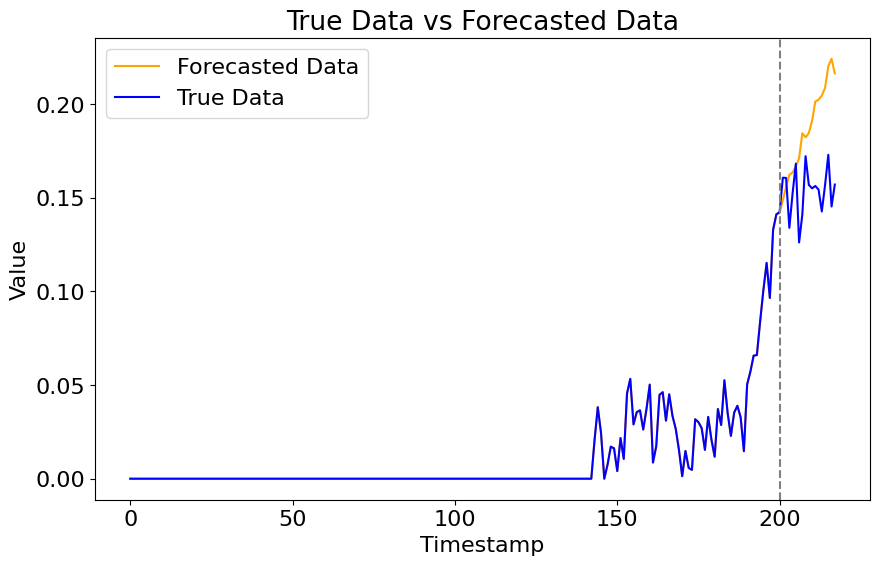

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

### First Model with Time2Vec:

In [ ]:
# Time2Vec layer implementation:

class T2V(Layer):

    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)

    def call(self, x):

        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)

        return K.concatenate([sin_trans, original], -1)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):

    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = T2V(output_dim=128)(input_layer)

    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)

    x = tfkl.Conv1D(256, 3, padding='same', activation='relu', name='conv')(x)

    x = Attention(256)(x)

    # Dropout version, to prevent overfitting:
    #x = tfkl.Dense(128)(x)
    #x = tfkl.Dropout(1/6)(x)

    x = tfkl.Dense(autoregressive_telescope)(x)

    output_layer = tf.keras.layers.Reshape((-1, 1))(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

(200, 1)
(18, 1)


In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 t2v (T2V)                   (None, 200, 129)          26128     
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 256)          264192    
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 256)          196864    
                                                                 
 attention_1 (Attention)     (None, 256)               66049     
                                                                 
 dense_5 (Dense)             (None, 18)                4626      
                                                   

In [ ]:
# Train the model, RMK. the output is associated to train session with autoregressive_telescope = 6
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

model.save('DirectForecastingAttention1_256_6_T2V_new')

Epoch 1/200
1447/1447 [==============================] - 75s 48ms/step - loss: 0.0106 - val_loss: 0.0070 - lr: 0.0010
Epoch 2/200
1447/1447 [==============================] - 69s 48ms/step - loss: 0.0067 - val_loss: 0.0064 - lr: 0.0010
Epoch 3/200
1447/1447 [==============================] - 72s 50ms/step - loss: 0.0062 - val_loss: 0.0063 - lr: 0.0010
Epoch 4/200
1447/1447 [==============================] - 72s 50ms/step - loss: 0.0060 - val_loss: 0.0063 - lr: 0.0010
Epoch 5/200
1447/1447 [==============================] - 72s 50ms/step - loss: 0.0057 - val_loss: 0.0061 - lr: 0.0010
Epoch 6/200
1447/1447 [==============================] - 72s 50ms/step - loss: 0.0055 - val_loss: 0.0060 - lr: 0.0010
Epoch 7/200
1447/1447 [==============================] - 72s 50ms/step - loss: 0.0054 - val_loss: 0.0058 - lr: 0.0010
Epoch 8/200
1447/1447 [==============================] - 72s 50ms/step - loss: 0.0052 - val_loss: 0.0058 - lr: 0.0010
Epoch 9/200
1447/1447 [==============================] -

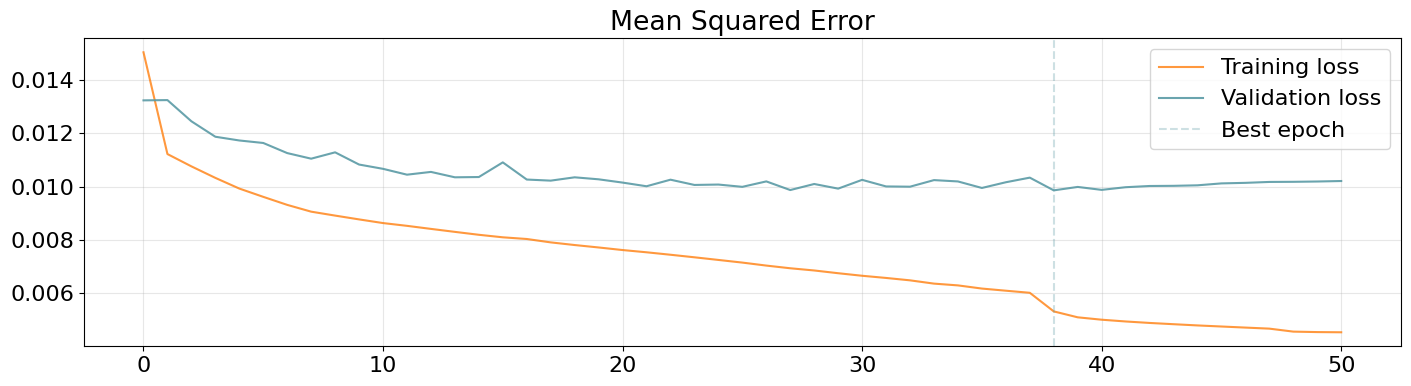

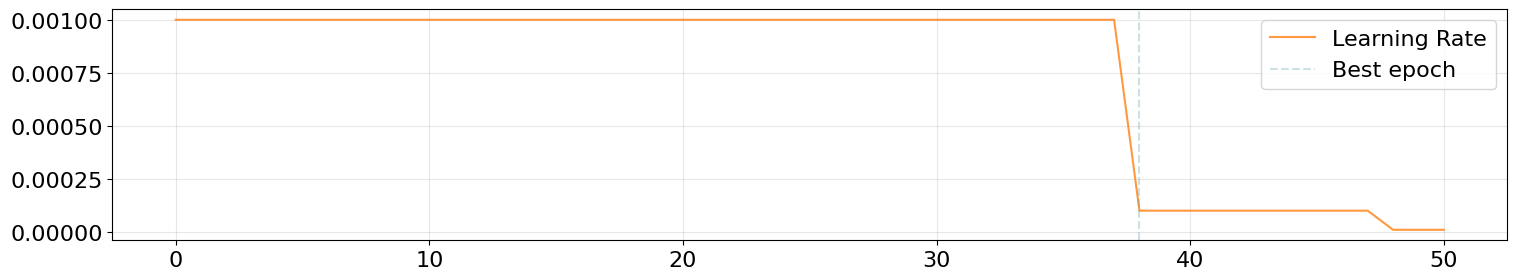

In [ ]:
# Training plot:
# RMK. the output is associated to train session with autoregressive_telescope = 18

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Evaluation:

# load the desired model:
model = tfk.models.load_model('DirectForecastingAttention1_256_18_T2V_new')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 18

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=150)

mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.008031981
Mean Absolute Error (MAE): 0.057151716


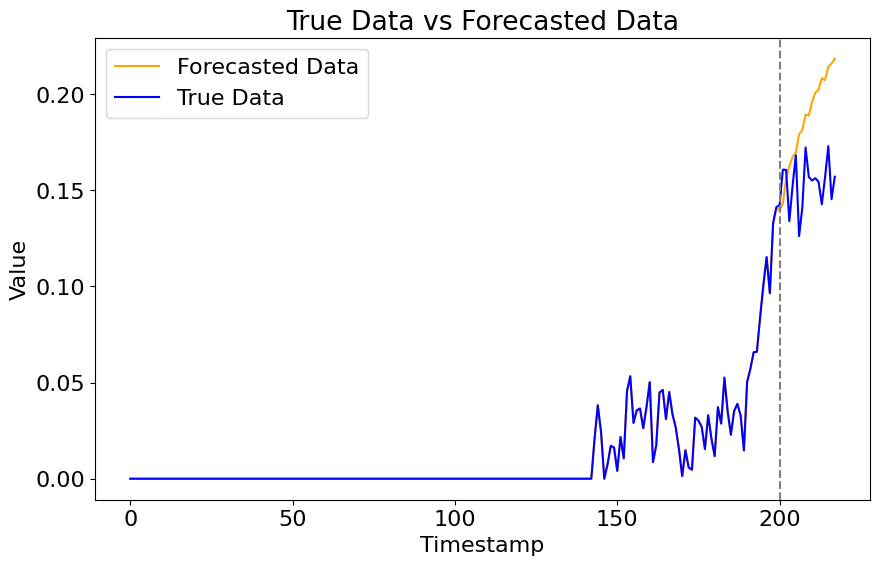

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

### First Model with MultiHeadAttention

In [ ]:
heads = 8
d_model = 256

def build_CONV_LSTM_model(input_shape, output_shape):

    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    x = tfkl.MultiHeadAttention(num_heads=heads, key_dim=d_model//heads)(x, x)

    x = tfkl.Conv1D(output_shape[1], 3, padding='same')(x)

    x = tfkl.Reshape((200,))(x)

    x = tf.keras.layers.Dense(autoregressive_telescope)(x)

    output_layer = tf.keras.layers.Reshape((-1, 1))(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

(200, 1)
(18, 1)


In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 conv (Conv1D)               (None, 200, 128)             49280     ['bidirectional_lstm[0][0]']  
                                                                                                  
 multi_head_attention (Mult  (None, 200, 128)             131968    ['conv[0][0]',  

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

model.save('DF_MultiHeadAttention1')

Epoch 1/200
1467/1467 [==============================] - 90s 58ms/step - loss: 0.0138 - val_loss: 0.0097 - lr: 0.0010
Epoch 2/200
1467/1467 [==============================] - 83s 57ms/step - loss: 0.0093 - val_loss: 0.0090 - lr: 0.0010
Epoch 3/200
1467/1467 [==============================] - 82s 56ms/step - loss: 0.0080 - val_loss: 0.0085 - lr: 0.0010
Epoch 4/200
1467/1467 [==============================] - 82s 56ms/step - loss: 0.0076 - val_loss: 0.0076 - lr: 0.0010
Epoch 5/200
1467/1467 [==============================] - 82s 56ms/step - loss: 0.0070 - val_loss: 0.0078 - lr: 0.0010
Epoch 6/200
1467/1467 [==============================] - 82s 56ms/step - loss: 0.0067 - val_loss: 0.0076 - lr: 0.0010
Epoch 7/200
1467/1467 [==============================] - 81s 56ms/step - loss: 0.0066 - val_loss: 0.0072 - lr: 0.0010
Epoch 8/200
1467/1467 [==============================] - 82s 56ms/step - loss: 0.0065 - val_loss: 0.0073 - lr: 0.0010
Epoch 9/200
1467/1467 [==============================] -

In [ ]:
# Evaluation:

# load the desired model:
model = tfk.models.load_model('DF_MultiHeadAttention1')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 9

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=150)

mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.00901009
Mean Absolute Error (MAE): 0.060833022


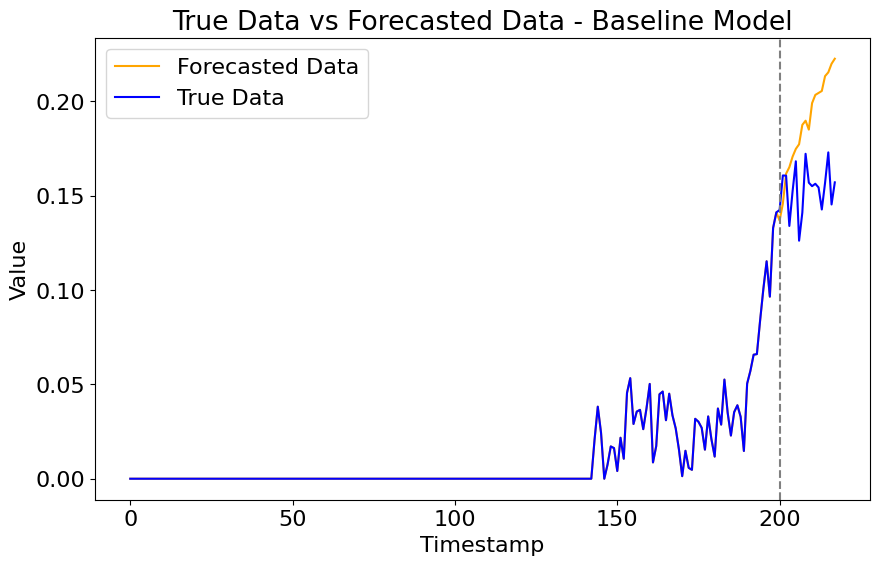

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

### MultiHead Attention Model:
##### add skip connection, layer normalization and dropout

In [ ]:
heads = 8
d_model = 128

def build_CONV_LSTM_model(input_shape, output_shape):

    assert input_shape[0] >= output_shape[0]

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    lstm_output = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    attn_output = tfkl.MultiHeadAttention(num_heads=heads, key_dim=d_model//heads)(lstm_output, lstm_output)

    attn_output = tfkl.Dropout(0.3)(attn_output)

    x = tfkl.LayerNormalization(epsilon=1e-6)(lstm_output + attn_output)

    x = tfkl.Conv1D(16, 3, padding='same', activation='relu')(x)

    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Flatten()(x)

    x = tf.keras.layers.Dense(autoregressive_telescope)(x)

    output_layer = tf.keras.layers.Reshape((-1, 1))(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

(200, 1)
(18, 1)


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 128)             33792     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 multi_head_attention_3 (Mu  (None, 200, 128)             66048     ['bidirectional_lstm[0][0]',  
 ltiHeadAttention)                                                   'bidirectional_lstm[0][0]']  
                                                                                    

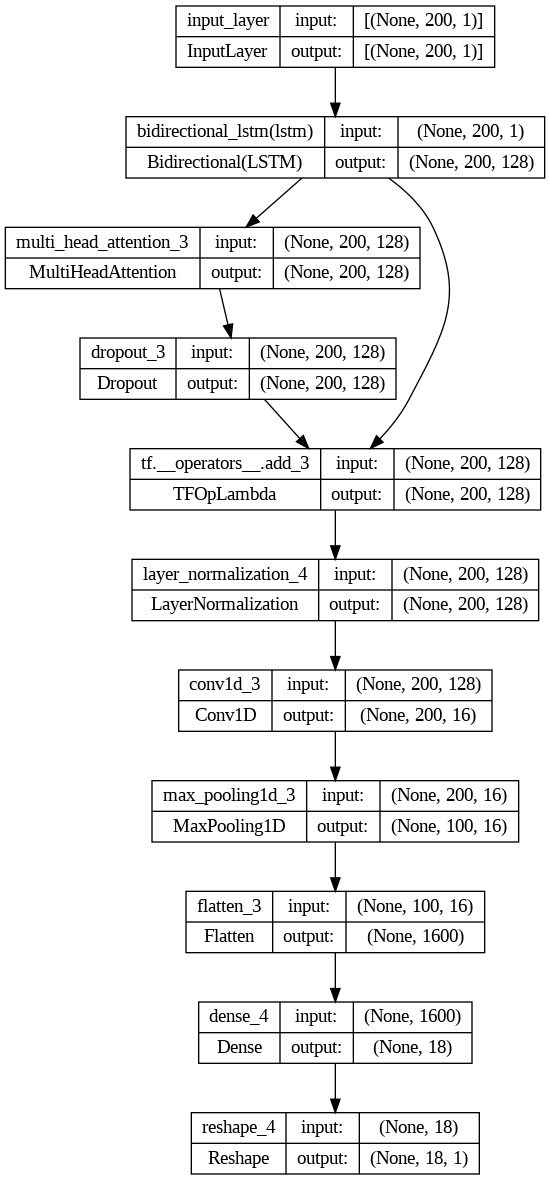

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

#model.save('DF_MultiHeadAttention2')

Epoch 1/200
1467/1467 [==============================] - 84s 53ms/step - loss: 0.0201 - val_loss: 0.0198 - lr: 0.0010
Epoch 2/200
1467/1467 [==============================] - 76s 52ms/step - loss: 0.0107 - val_loss: 0.0228 - lr: 0.0010
Epoch 3/200
1467/1467 [==============================] - 77s 52ms/step - loss: 0.0093 - val_loss: 0.0235 - lr: 0.0010
Epoch 4/200
1467/1467 [==============================] - 76s 52ms/step - loss: 0.0087 - val_loss: 0.0191 - lr: 0.0010
Epoch 5/200
1467/1467 [==============================] - 78s 53ms/step - loss: 0.0082 - val_loss: 0.0201 - lr: 0.0010
Epoch 6/200
1467/1467 [==============================] - 77s 53ms/step - loss: 0.0080 - val_loss: 0.0202 - lr: 0.0010
Epoch 7/200
1467/1467 [==============================] - 77s 52ms/step - loss: 0.0078 - val_loss: 0.0225 - lr: 0.0010
Epoch 8/200
1467/1467 [==============================] - 77s 52ms/step - loss: 0.0077 - val_loss: 0.0227 - lr: 0.0010
Epoch 9/200
1467/1467 [==============================] -

In [ ]:
# Evaluation:

# load the desired model:
model = tfk.models.load_model('DF_MultiHeadAttention2')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 9

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=150)

mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope) # suffered from overfitting problems, now solved, to be trained again and re-tested

Mean Squared Error (MSE): 0.036938775
Mean Absolute Error (MAE): 0.1520635


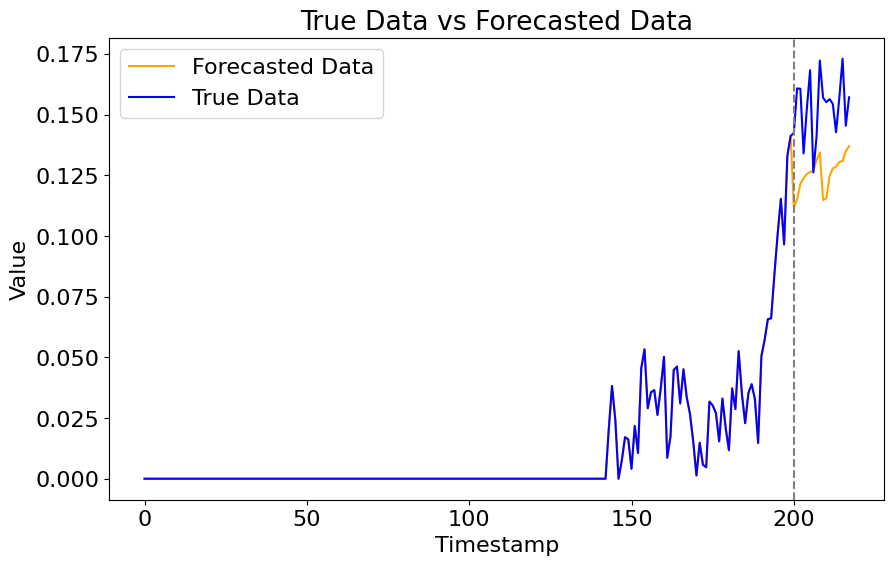

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

### Bahdanau Attention Model:

In [ ]:
# Bahdanau attention layer implementation:

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):

    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv1D(32, 3, padding='same', activation='relu', name='conv')(input_layer)

    x = tfkl.LayerNormalization(epsilon=1e-6)(x)

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm', dropout=0.3), name='bidirectional_lstm')(x) # TODO

    x = attention()(x)

    x = tf.keras.layers.Dense(autoregressive_telescope)(x)

    output_layer = tf.keras.layers.Reshape((-1, 1))(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

(200, 1)
(18, 1)


In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 conv (Conv1D)               (None, 200, 32)           128       
                                                                 
 layer_normalization_3 (Lay  (None, 200, 32)           64        
 erNormalization)                                                
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          49664     
 ctional)                                                        
                                                                 
 attention (attention)       (None, 128)               328       
                                                                 
 dense_3 (Dense)             (None, 18)            

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

#model.save('DF_BahdanauAttention1')

Epoch 1/200
1467/1467 [==============================] - 42s 22ms/step - loss: 0.0166 - val_loss: 0.0120 - lr: 0.0010
Epoch 2/200
1467/1467 [==============================] - 32s 22ms/step - loss: 0.0099 - val_loss: 0.0095 - lr: 0.0010
Epoch 3/200
1467/1467 [==============================] - 32s 22ms/step - loss: 0.0094 - val_loss: 0.0092 - lr: 0.0010
Epoch 4/200
1467/1467 [==============================] - 32s 22ms/step - loss: 0.0085 - val_loss: 0.0083 - lr: 0.0010
Epoch 5/200
1467/1467 [==============================] - 31s 21ms/step - loss: 0.0075 - val_loss: 0.0082 - lr: 0.0010
Epoch 6/200
1467/1467 [==============================] - 31s 21ms/step - loss: 0.0072 - val_loss: 0.0077 - lr: 0.0010
Epoch 7/200
1467/1467 [==============================] - 32s 22ms/step - loss: 0.0070 - val_loss: 0.0078 - lr: 0.0010
Epoch 8/200
1467/1467 [==============================] - 31s 21ms/step - loss: 0.0069 - val_loss: 0.0077 - lr: 0.0010
Epoch 9/200
1467/1467 [==============================] -

In [ ]:
# Evaluation:

# load the desired model:
model = tfk.models.load_model('DF_BahdanauAttention1')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 9

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=150)

mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.009813199
Mean Absolute Error (MAE): 0.067421965


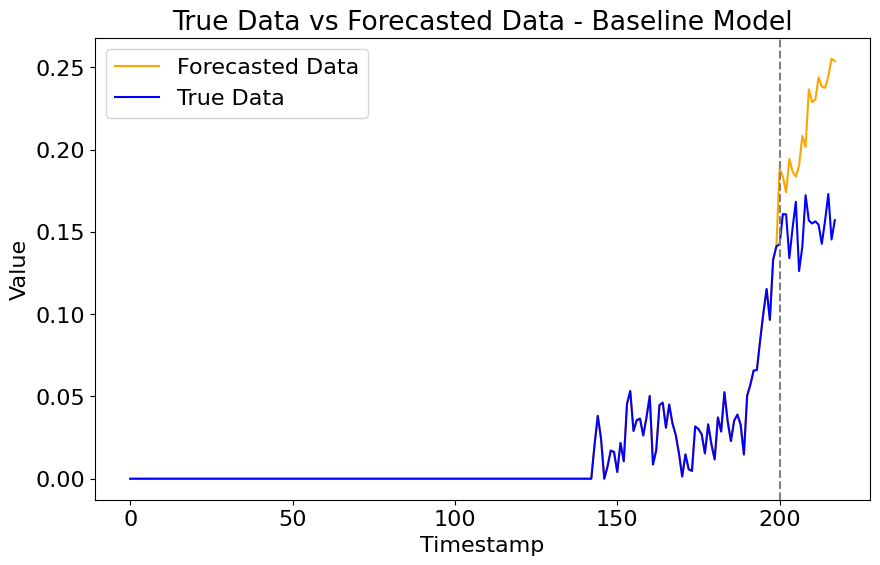

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

### ResNet like model, only convolutional

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Add, Flatten, Dense

residual_blocks = 6

# Define input tensor
input_tensor = Input(shape=input_shape)

# Initial Conv1D layer
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_tensor)

# Residual blocks
for _ in range(residual_blocks):  # number of residual blocks
    residual = x

    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)

    # Skip connection
    x = Add()([x, residual])

    x = MaxPooling1D(pool_size=2)(x)  # Downsample

# Flatten before Dense layers
x = Flatten()(x)

# Dense layers for final prediction
x = Dense(units=128, activation='relu')(x)
output = Dense(units=output_shape[0], activation='linear')(x)  # Output shape: (9, 1)

# Create model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 200, 32)              128       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 200, 32)              3104      ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 200, 32)              3104      ['conv1d_1[0][0]']            
                                                                                              

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-4)
    ]
).history

model.save('Resnet_conv_9')

Epoch 1/200
1438/1438 [==============================] - 23s 9ms/step - loss: 0.0096 - val_loss: 0.0086 - lr: 0.0010
Epoch 2/200
1438/1438 [==============================] - 13s 9ms/step - loss: 0.0073 - val_loss: 0.0076 - lr: 0.0010
Epoch 3/200
1438/1438 [==============================] - 13s 9ms/step - loss: 0.0068 - val_loss: 0.0080 - lr: 0.0010
Epoch 4/200
1438/1438 [==============================] - 13s 9ms/step - loss: 0.0067 - val_loss: 0.0073 - lr: 0.0010
Epoch 5/200
1438/1438 [==============================] - 13s 9ms/step - loss: 0.0065 - val_loss: 0.0072 - lr: 0.0010
Epoch 6/200
1438/1438 [==============================] - 13s 9ms/step - loss: 0.0064 - val_loss: 0.0072 - lr: 0.0010
Epoch 7/200
1438/1438 [==============================] - 12s 9ms/step - loss: 0.0063 - val_loss: 0.0073 - lr: 0.0010
Epoch 8/200
1438/1438 [==============================] - 13s 9ms/step - loss: 0.0062 - val_loss: 0.0071 - lr: 0.0010
Epoch 9/200
1438/1438 [==============================] - 13s 9ms

In [ ]:
# load the desired model:
model = tfk.models.load_model('Resnet_conv_9')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 9

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=max_padding)
print(np.shape(X_test_reg))
print(np.shape(y_test_reg))

(10567, 200)
(10567, 18)


In [ ]:
mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.008371301
Mean Absolute Error (MAE): 0.059236355


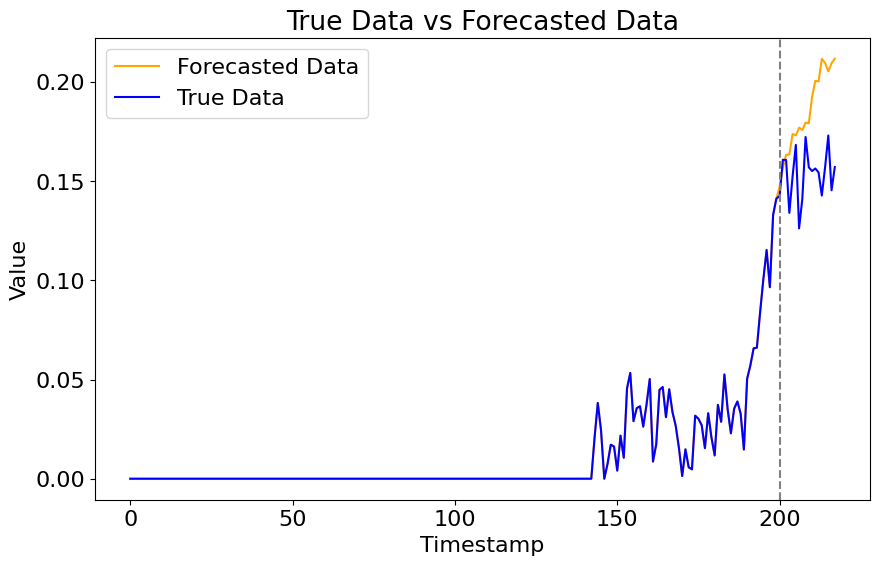

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

### Resnet like model with LSTM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Add, Activation, BatchNormalization, Flatten, MaxPooling1D, Reshape

def residual_block(inputs, units):
    # Define the main path
    x = LSTM(units, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Short skip connection
    skip = LSTM(units, return_sequences=True)(inputs)
    skip = BatchNormalization()(skip)

    # Add the skip connection
    x = Add()([x, skip])
    x = Activation('relu')(x)

    return x

def create_res_rnn_model(input_shape, output_shape, num_units=64, num_blocks=3):
    inputs = Input(shape=input_shape)
    x = inputs

    # Adding residual blocks
    for _ in range(num_blocks):
        x = residual_block(x, num_units)

    # Output layer
    x = MaxPooling1D(pool_size=200)(x)
    x = Dense(units = 128, activation ='relu')(x)
    x = Dense(units=output_shape[0], activation='linear')(x)
    x = LSTM(output_shape[0], return_sequences=True)(x)
    x = Dense(output_shape[0])(x)
    outputs = Reshape((9,1)) (x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = create_res_rnn_model(input_shape, output_shape)

# Compile the model (choose appropriate optimizer, loss, etc.)
model.compile(optimizer='adam', loss='mse')  # Example, you can change these settings as needed

# Display model summary
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 lstm_81 (LSTM)              (None, 200, 64)              16896     ['input_18[0][0]']            
                                                                                                  
 batch_normalization_96 (Ba  (None, 200, 64)              256       ['lstm_81[0][0]']             
 tchNormalization)                                                                                
                                                                                                  
 lstm_82 (LSTM)              (None, 200, 64)              16896     ['input_18[0][0]']     

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-4)
    ]
).history

model.save('resnet_lstm')

Epoch 1/200
1438/1438 [==============================] - 121s 75ms/step - loss: 0.0141 - val_loss: 0.0127 - lr: 0.0010
Epoch 2/200
1438/1438 [==============================] - 87s 61ms/step - loss: 0.0093 - val_loss: 0.0096 - lr: 0.0010
Epoch 3/200
1438/1438 [==============================] - 87s 61ms/step - loss: 0.0083 - val_loss: 0.0252 - lr: 0.0010
Epoch 4/200
1438/1438 [==============================] - 87s 61ms/step - loss: 0.0078 - val_loss: 0.0131 - lr: 0.0010
Epoch 5/200
1438/1438 [==============================] - 89s 62ms/step - loss: 0.0074 - val_loss: 0.0088 - lr: 0.0010
Epoch 6/200
1438/1438 [==============================] - 87s 60ms/step - loss: 0.0073 - val_loss: 0.0096 - lr: 0.0010
Epoch 7/200
1438/1438 [==============================] - 87s 61ms/step - loss: 0.0070 - val_loss: 0.0091 - lr: 0.0010
Epoch 8/200
1438/1438 [==============================] - 87s 60ms/step - loss: 0.0068 - val_loss: 0.0091 - lr: 0.0010
Epoch 9/200
1438/1438 [==============================] 

In [ ]:
# load the desired model:
model = tfk.models.load_model('resnet_lstm')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 9

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=max_padding)
print(np.shape(X_test_reg))
print(np.shape(y_test_reg))

(10567, 200)
(10567, 18)


In [ ]:
mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.008575387
Mean Absolute Error (MAE): 0.060376696


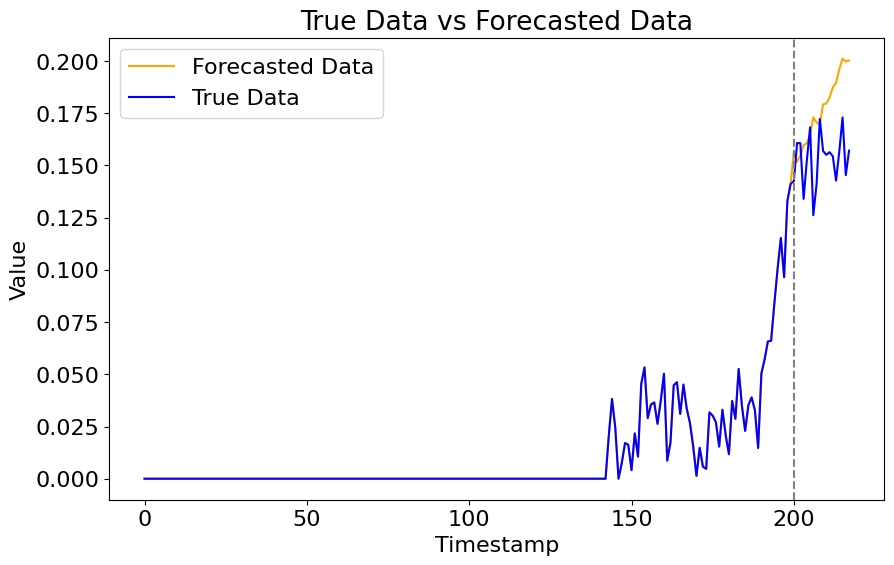

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

### Resnet like model with GRU

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Add, Activation, BatchNormalization

def residual_block(inputs, units):
    # Define the main path
    x = GRU(units, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Short skip connection
    skip = GRU(units, return_sequences=True)(inputs)
    skip = BatchNormalization()(skip)

    # Add the skip connection
    x = Add()([x, skip])
    x = Activation('relu')(x)

    return x

def create_res_gru_model(input_shape, output_shape, num_units=64, num_blocks=3):
    inputs = Input(shape=input_shape)
    x = inputs

    # Adding residual blocks
    for _ in range(num_blocks):
        x = residual_block(x, num_units)

    # Output layer

    x = MaxPooling1D(pool_size=200)(x)
    x = Dense(units = 128, activation ='relu')(x)
    x = Dense(units=output_shape[0], activation='linear')(x)
    x = GRU(output_shape[1], return_sequences=True)(x)
    x = Dense(output_shape[1])(x)
    x = Dense(output_shape[0])(x)
    outputs = Reshape((9,1)) (x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = create_res_gru_model(input_shape, output_shape)

# Compile the model (choose appropriate optimizer, loss, etc.)
model.compile(optimizer='adam', loss='mse')  # Example, you can change these settings as needed

# Display model summary
model.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 gru_29 (GRU)                (None, 200, 64)              12864     ['input_19[0][0]']            
                                                                                                  
 batch_normalization_102 (B  (None, 200, 64)              256       ['gru_29[0][0]']              
 atchNormalization)                                                                               
                                                                                                  
 gru_30 (GRU)                (None, 200, 64)              12864     ['input_19[0][0]']     

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-4)
    ]
).history

model.save('resnet_gru')

Epoch 1/200
1438/1438 [==============================] - 98s 59ms/step - loss: 0.0556 - val_loss: 0.0109 - lr: 0.0010
Epoch 2/200
1438/1438 [==============================] - 82s 57ms/step - loss: 0.0092 - val_loss: 0.0094 - lr: 0.0010
Epoch 3/200
1438/1438 [==============================] - 83s 58ms/step - loss: 0.0087 - val_loss: 0.0104 - lr: 0.0010
Epoch 4/200
1438/1438 [==============================] - 82s 57ms/step - loss: 0.0085 - val_loss: 0.0101 - lr: 0.0010
Epoch 5/200
1438/1438 [==============================] - 82s 57ms/step - loss: 0.0083 - val_loss: 0.0110 - lr: 0.0010
Epoch 6/200
1438/1438 [==============================] - 82s 57ms/step - loss: 0.0083 - val_loss: 0.0093 - lr: 0.0010
Epoch 7/200
1438/1438 [==============================] - 83s 58ms/step - loss: 0.0082 - val_loss: 0.0093 - lr: 0.0010
Epoch 8/200
1438/1438 [==============================] - 82s 57ms/step - loss: 0.0081 - val_loss: 0.0084 - lr: 0.0010
Epoch 9/200
1438/1438 [==============================] -

In [ ]:
# load the desired model:
model = tfk.models.load_model('GRU_6_150')
# fix the corresponding autoregressive_telescope value:
autoregressive_telescope = 6

X_test_reg, y_test_reg = build_sequences(test_data, test_valid_periods, window, stride, telescope, max_padding=max_padding)
print(np.shape(X_test_reg))
print(np.shape(y_test_reg))

(10567, 200)
(10567, 18)


In [ ]:
mse, mae = compute_evaluation_metrics(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)

Mean Squared Error (MSE): 0.008706035
Mean Absolute Error (MAE): 0.059126154


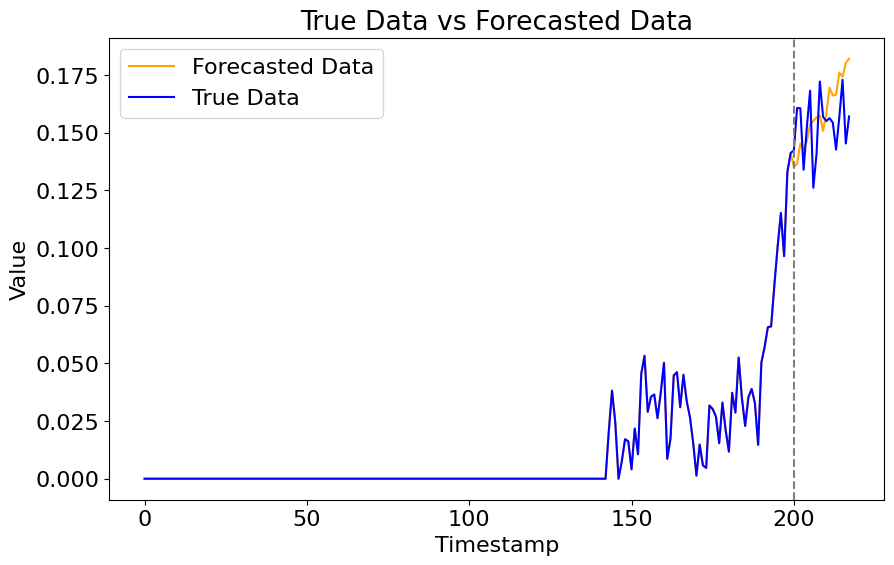

In [ ]:
plot_prediction(model, X_test_reg, y_test_reg, telescope, autoregressive_telescope)